In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize=(9, 3)
else:
    figsize=(14, 4)

from util import util
import os
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
from tensorflow.keras import regularizers

# Specify the data folder
data_folder = os.path.join('..', 'data')

2023-11-12 13:11:44.400806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 13:11:44.432080: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 13:11:44.432110: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 13:11:44.432133: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 13:11:44.437470: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 13:11:44.438085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

# Fairness in Machine Learning

## Fairness Issues in Machine Learning

**Say we want to estimate the risk of violent crimes in given population**

<center><img src="assets/minority-report.jpg" width=25%/></center>

* This is obviously a very _ethically sensitive (and questionable) task_
* ...Since our model may easily end up _discriminating some social groups_

**This makes it a good test case to discuss _fairness in data-driven methods_**


## Fairness in Data-Driven Methods

**Fairness in data-driven methods is _very actual topic_**

* As data-driven systems become more pervasive
* They have the potential to significantly affect social groups

**Once you deploy an AI model, _performance is not enough_**

* You might have stellar accuracy and efficient inference
* ...And still end up causing all sort of havoc

**This is so critical that the topic is about _starting to be regulated_**

* The EU has drafted [Ethics Guidelines for Trustworthy AI](https://digital-strategy.ec.europa.eu/en/library/ethics-guidelines-trustworthy-ai)
* ...And is in the process of releasing a big [AI act](https://www.europarl.europa.eu/news/en/headlines/society/20230601STO93804/eu-ai-act-first-regulation-on-artificial-intelligence)
* In some fields, models that do not comply with some rules cannot be deployed

## Loading and Preparing the Dataset

**We will run an experiment on the ["crime" UCI dataset](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime)**

We will use a pre-processed version made available by our support module:

In [2]:
data = util.load_communities_data(data_folder)
data

,communityname,state,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
1008,EastLampetertownship,PA,5,11999,0,0.1203,0.2544,0.1208,0.1302,0.5776,...,0.0288,0.8132,0.6033,0.8597,0.9219,20.7,580.7,0.0103,0.0000,147.49
1271,EastProvidencecity,RI,6,50380,0,0.1171,0.2459,0.1159,0.1660,1.0000,...,0.1474,0.6561,0.6557,0.8929,0.9252,13.9,3629.0,0.0357,0.0000,150.88
1936,Betheltown,CT,9,17541,0,0.1356,0.2507,0.1138,0.0804,0.8514,...,0.0853,0.4878,0.5953,0.8485,0.8689,17.4,1008.2,0.0252,0.0000,95.47
1601,Crowleycity,LA,8,13983,0,0.1506,0.2587,0.1234,0.1302,0.0000,...,0.0029,0.9314,0.5898,0.9219,0.9769,4.7,2957.5,0.0098,0.0000,1029.02
293,Pawtucketcity,RI,2,72644,0,0.1230,0.2725,0.1276,0.1464,1.0000,...,0.1771,0.6363,0.5807,0.8805,0.8906,9.1,8027.0,0.0318,0.1103,458.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,RockyMountcity,NC,8,48997,0,0.1454,0.2653,0.1247,0.1190,1.0000,...,0.0077,0.8138,0.5211,0.7676,0.9057,25.9,1893.2,0.0056,0.0354,1275.11
1822,Amarillocity,TX,9,157615,0,0.1391,0.2660,0.1244,0.1085,1.0000,...,0.0412,0.6651,0.4834,0.7204,0.9198,91.1,1730.1,0.0085,0.1600,671.46
2207,WestHaventown,CT,10,54021,0,0.1186,0.2772,0.1318,0.1339,1.0000,...,0.0837,0.7031,0.5911,0.8626,0.9148,11.2,4812.3,0.0335,0.0566,285.73
1081,Humblecity,TX,5,12060,0,0.1545,0.3184,0.1530,0.0719,1.0000,...,0.0638,0.5983,0.3252,0.7522,0.8945,10.2,1180.0,0.0111,0.0000,771.88


The target is "violentPerPop" (number of violent offenders per 100K people)

## Loading and Preparing the Dataset

**We start to prepare the data by identifying all numerical attributes**

In [3]:
attributes, target = data.columns[3:-1], data.columns[-1]
nf = [a for a in attributes if a != 'race'] + [target]

* The only categorical input is "race" (0 = primarily white, 1 = primarily black)
* ...And this is also the attribute that we will use to check for discrimination

**The we standardize all numeric attributes as usual**

In [4]:
tr_frac = 0.8 # 80% data for training
tr_sep = int(len(data) * tr_frac)
tmp = data.iloc[:tr_sep]

sdata = data.copy()
sdata[nf] = (sdata[nf] - tmp[nf].mean()) / (tmp[nf].std())

sdata[attributes] = sdata[attributes].astype(np.float32)
sdata[target] = sdata[target].astype(np.float32)

## Loading and Preparing the Dataset

**Finally, we separate the training and test set**

In [5]:
tr = sdata.iloc[:tr_sep]
ts = sdata.iloc[tr_sep:]
tr.describe()

,fold,pop,race,pct12-21,pct12-29,pct16-24,pct65up,pctUrban,medIncome,pctWwage,...,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,landArea,popDensity,pctUsePubTrans,pctOfficDrugUnit,violentPerPop
count,1594.000000,1594.000000,1594.000000,1.594000e+03,1.594000e+03,1594.000000,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000,...,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000,1.594000e+03,1.594000e+03,1.594000e+03,1.594000e+03,1594.000000
mean,5.515056,0.000000,0.031995,-1.196580e-09,-2.393160e-09,0.000000,-2.393160e-09,1.555554e-08,-3.589740e-09,0.000000,...,-1.794870e-09,5.982900e-10,2.393160e-09,-2.393160e-09,0.000000,-3.589740e-09,-2.991450e-09,1.794870e-09,2.393160e-09,0.000000
std,2.912637,1.000000,0.176042,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,9.999999e-01,1.000000e+00,1.000000,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
min,1.000000,-0.196135,0.000000,-2.175701e+00,-2.922249e+00,-1.572079,-2.139933e+00,-1.562290e+00,-1.545183e+00,-5.916497,...,-8.519060e-01,-3.150054e+00,-3.702133e+00,-4.496539e+00,-7.197635,-3.165063e-01,-9.622333e-01,-6.146801e-01,-3.475005e-01,-0.951130
25%,3.000000,-0.177169,0.000000,-4.967758e-01,-5.304008e-01,-0.460043,-6.478973e-01,-1.562290e+00,-7.508521e-01,-0.605185,...,-6.275661e-01,-6.782481e-01,-6.298359e-01,-4.733628e-01,-0.415063,-2.329571e-01,-5.617804e-01,-5.428441e-01,-3.475005e-01,-0.694305
50%,5.000000,-0.141106,0.000000,-1.909697e-01,-1.486426e-01,-0.253682,-3.945406e-02,6.843710e-01,-2.136893e-01,0.060002,...,-3.515672e-01,1.102082e-01,4.725438e-02,2.024060e-01,0.247268,-1.519787e-01,-2.704456e-01,-3.689513e-01,-3.475005e-01,-0.340868
75%,8.000000,-0.045777,0.000000,2.007248e-01,2.358963e-01,0.052345,5.321295e-01,6.843710e-01,5.675405e-01,0.704183,...,2.042036e-01,8.156845e-01,6.820266e-01,7.021766e-01,0.673826,5.800705e-03,1.730029e-01,8.138642e-02,-3.475005e-01,0.333813
max,10.000000,32.775719,1.000000,8.726096e+00,6.657856e+00,7.807232,8.473559e+00,6.843710e-01,6.673299e+00,2.350919,...,6.058806e+00,1.916122e+00,2.573177e+00,1.803599e+00,1.471447,3.420858e+01,1.440461e+01,1.015181e+01,1.595404e+01,7.140815


## Baseline

**Let's establish a baseline by tackling the task via Linear Regression**

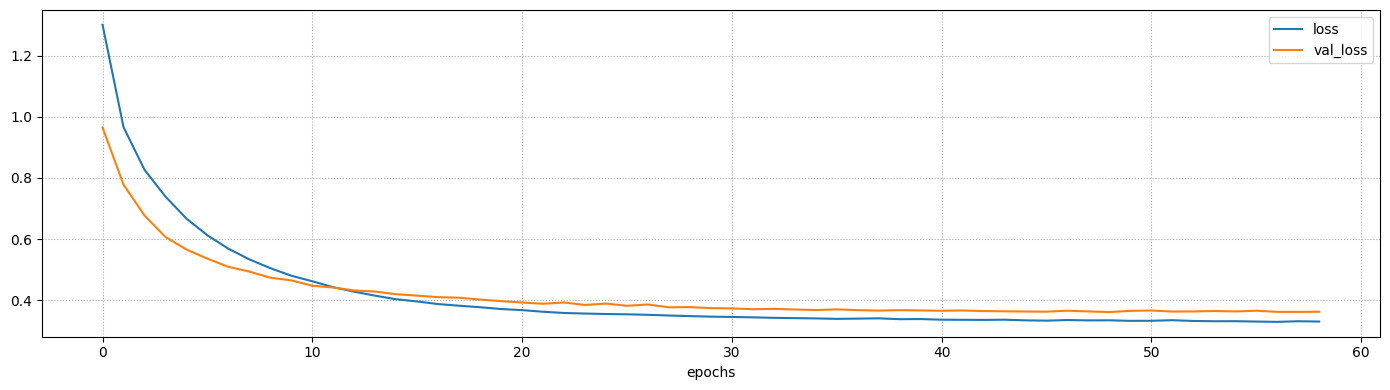

Final loss: 0.3298 (training), 0.3620 (validation)


In [6]:
nn = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[], output_activation='linear')
history = util.train_nn_model(nn, tr[attributes], tr[target], loss='mse', batch_size=32, epochs=400, verbose=0, validation_split=0.2)
util.plot_training_history(history, figsize=figsize)

## Baseline Evaluation

**...And let's check the results**

In [7]:
tr_pred = nn.predict(tr[attributes], verbose=0)
r2_tr, mae_tr = r2_score(tr[target], tr_pred), mean_absolute_error(tr[target], tr_pred)
ts_pred = nn.predict(ts[attributes], verbose=0)
r2_ts, mae_ts = r2_score(ts[target], ts_pred), mean_absolute_error(ts[target], ts_pred)
print(f'R2 score: {r2_tr:.2f} (training), {r2_ts:.2f} (test)')
print(f'MAE: {mae_tr:.2f} (training), {mae_ts:.2f} (test)')

R2 score: 0.67 (training), 0.60 (test)
MAE: 0.39 (training), 0.46 (test)


* They are definitely not [PreCrime](https://en.wikipedia.org/wiki/Minority_Report_(film)) level, but they are not bad
* Some improvements (not much) can be obtained with a Deeper model

**Linear Regression is an interpretable ML model**

* In particular, we can have evaluate the _importance of each input attribute_
* This can be done in LR by _inspecting the weights_

We could try this approach to check for discrimination

# Important Attributes in Linear Regression

## Important Attributes in Linear Regression

**Let's _plot the weights by decreasing (absolute) value_**

* If _all attributes are standardized/normalized_ (so they have similar ranges)
* ...Then the larger the (absolute) weight, the larger the impact

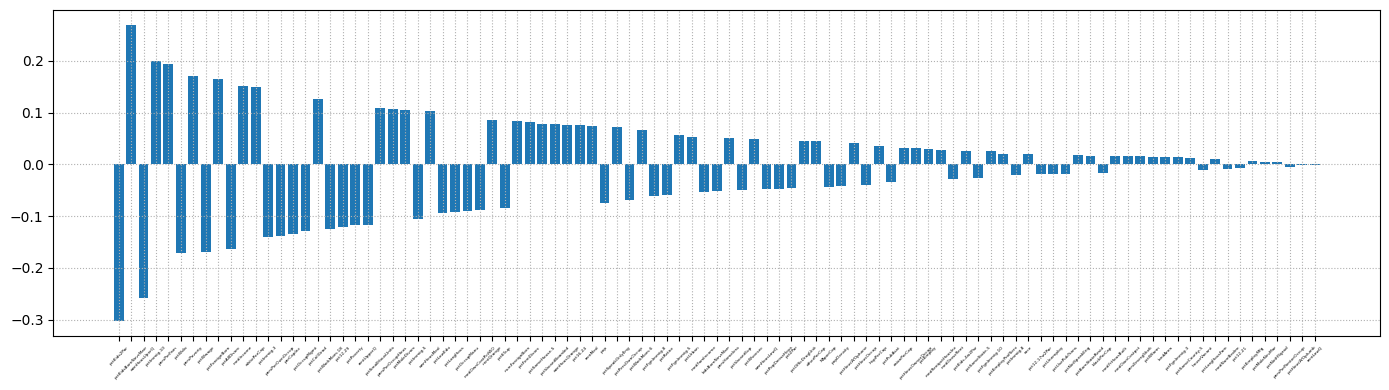

In [8]:
lr_weights = nn.get_weights()[0].ravel()
util.plot_lr_weights(lr_weights, attributes, figsize=figsize)

* Unfortunately, itthere are many large-ish weights

## Lasso

**We can fix this by adding an L1 regularizer to obtain [_LASSO (Regression)_](https://en.wikipedia.org/wiki/Lasso_(statistics))**

The regularizer penalizes weight magnitudes via _a fixed rate $\alpha$_, i.e.:

$$
L(y, f(x, \theta)) = \|\theta^T x - y\|_2^2 + \alpha \|\theta\|_1
$$

* Attributes for which the loss reduction does not match the regularization rate...
* ...Will be kept at zero, resulting in a _sparse weight vector_

**Lasso is available in scikit-learn, and can be implemented in Keras/Tensorflow**

We just need to add L1 regularization over the output neuron:

```python
...
model_out = layers.Dense(output_shape, activation=output_activation,
        kernel_regularizer=regularizers.l1(l1=1e-3))(x)
...
```

## Lasso

**We can train the Lasso model as usual**

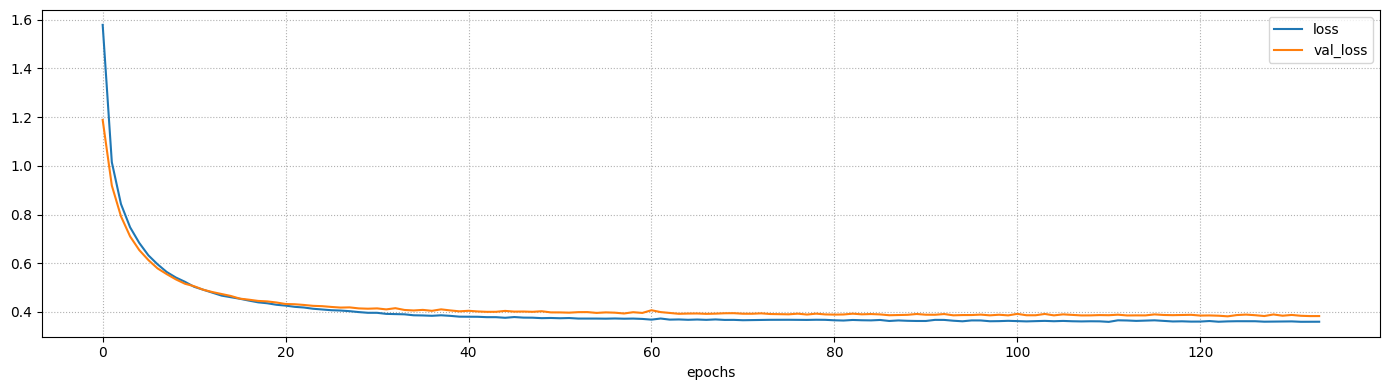

Final loss: 0.3598 (training), 0.3830 (validation)


In [9]:
nn2 = util.build_nn_model(input_shape=len(attributes), output_shape=1, hidden=[], output_activation='linear',
                          kernel_regularizers=[regularizers.l1(l1=1e-2)])
history = util.train_nn_model(nn2, tr[attributes], tr[target], loss='mse', batch_size=32, epochs=400, verbose=0, validation_split=0.2)
util.plot_training_history(history, figsize=figsize)

## Lasso Evaluation

**The results are on par with Linear Regression**

In [10]:
tr_pred2 = nn2.predict(tr[attributes], verbose=0)
r2_tr2, mae_tr2 = r2_score(tr[target], tr_pred2), mean_absolute_error(tr[target], tr_pred2)
ts_pred2 = nn2.predict(ts[attributes], verbose=0)
r2_ts2, mae_ts2 = r2_score(ts[target], ts_pred2), mean_absolute_error(ts[target], ts_pred2)

print(f'R2 score: {r2_tr2:.2f} (training), {r2_ts2:.2f} (test)')
print(f'MAE: {mae_tr2:.2f} (training), {mae_ts2:.2f} (test)')

R2 score: 0.66 (training), 0.61 (test)
MAE: 0.39 (training), 0.45 (test)


* The L1 term actually acts also as a traditional regularizer...
* ...And may therefore help to _prevent overfitting_

## Important Attributes in Lasso

**The main difference between LR and Lasso is in the weight vector**

Lasso weights are _sparse_,  i.e. only a few attributes will have a significant impact

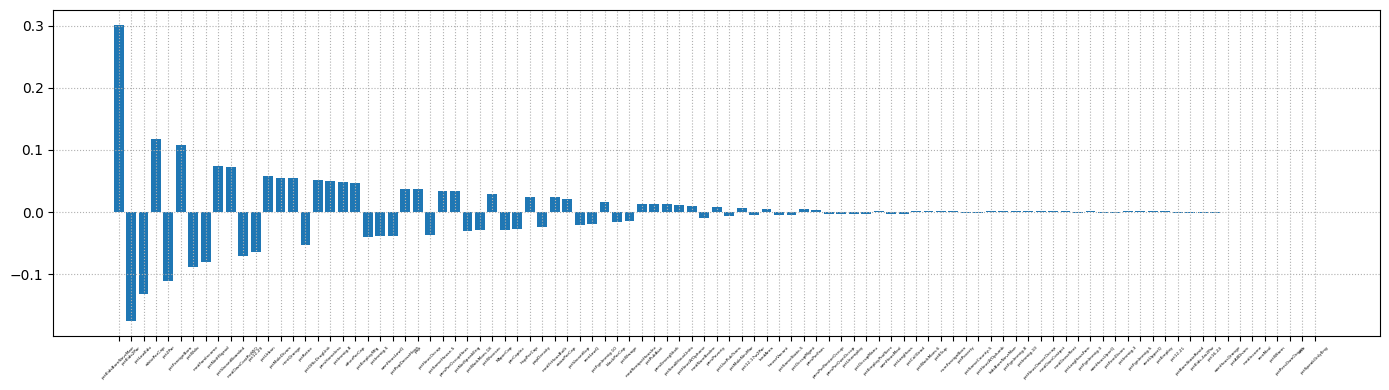

In [11]:
lasso_weights = nn2.get_weights()[0].ravel()
util.plot_lr_weights(lasso_weights, attributes, figsize=figsize)

## Important Attributes in Lasso

**Let's zoom in on the 15 most important attributes**

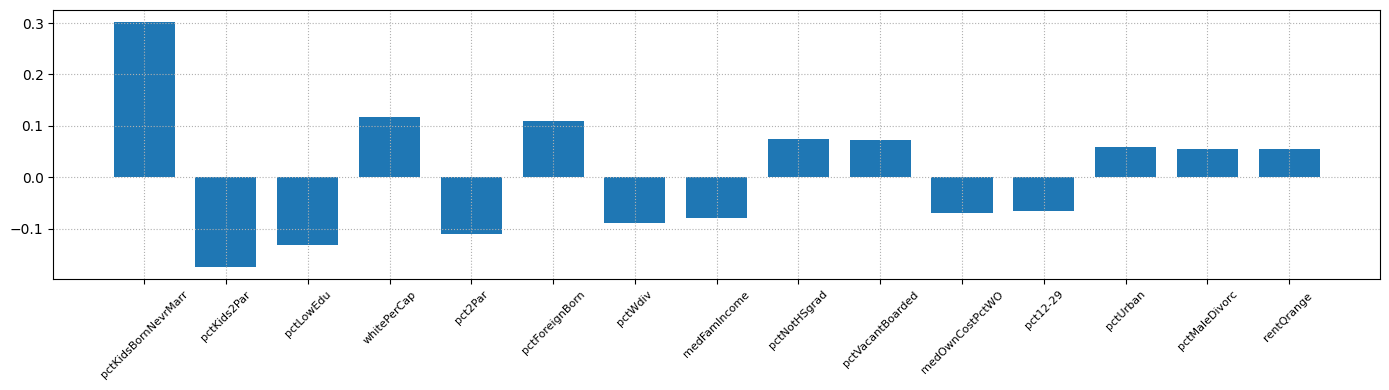

In [12]:
lasso_weights = nn2.get_weights()[0].ravel()
util.plot_lr_weights(lasso_weights, attributes, cap_num=15, figsize=figsize)

**The attribute "race" is nowhere to be seen!**

* This is _looks_ reassuring for our potential discrimination concerns
* ...But in fact _it is not_ (and we will proceed to check it)

# Fairness Metrics

## Fairness Metrics

**Measuring fairness is complicated**

* As with all things related to metrics, measuring is per-se questionable
* ...But if we want to obtain algorithms, it's a necessary step

**[Several fairness metrics](https://dl.acm.org/doi/abs/10.1145/3457607?casa_token=7K5cttUU8CMAAAAA:eOTbdtdJRlHvrexenK9WGomYr4EZJ4I5xEUAQiyxmNAwVzAcnfDnjzBXt_D2aU4vfLRNM7VPC-g) have been proposed**

Here we will focus on the idea of _disparate treatment_

* We will check whether different groups
* ...As defined by the value of a protected attribute ("race" for us)
* Are associated to different predictions

## Disparate Treatment

**Our model _treats the groups differently_**

...Even if race is not an important attribute

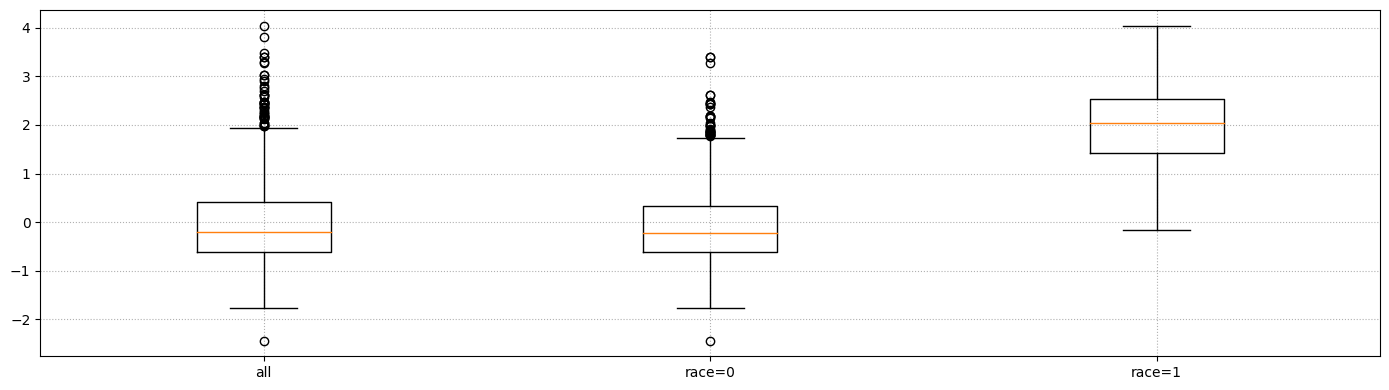

In [13]:
protected={'race': (0, 1)}
util.plot_pred_by_protected(tr, tr_pred, protected={'race': (0, 1)}, figsize=figsize)

**This would happen _even if removed the "race" attribute_**

* The model would still be able to access race information
* ...By simply using correlates

## Discrimination Indexes

**Therefore, checking the important attributes is not enough**

* We need to _measure disparate treatment_ for the trained model
* ...And as we mentioned there are alternative metrics to do that

**We will use the one from [this AAAI paper](https://www.aaai.org/ojs/index.php/AAAI/article/download/3943/3821)**

* Given a set of categorical _protected attribute (indexes) $J_p$_
* ...The Disparate Impact Discrimination Index (for regression) is given by:

$$
\text{DIDI}_r = \sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* Where $D_j$ is the domain of attribute $j$
* ...And $I_{j,v}$ is the set of example such that attribute $j$ has value $v$




## DIDI

**Let's make some intuitive sense of the $\text{DIDI}_r$ formula**

$$
\sum_{j \in J_p} \sum_{v \in D_{j}} \left|\frac{1}{m} \sum_{i=1}^m y_i - \frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}\right|
$$

* $\frac{1}{m} \sum_{i=1}^m y_i$ is just the average predicted value
* ...For examples where the protected attribute takes specific values
* $\frac{1}{|I_{j,v}|} \sum_{i \in I_{j,v}} y_{i}$ is the average prediction for a social group

**We penalize the group predictions for _deviating from the global average_**

* Obviously this is not necessarily the best definition, but it is something
* In general, different tasks will call for different discrimination indexes

...And don't forget the whole "can we actually measure ethics" issue ;-)

## DIDI

**We can compute the DIDI via the following function**

```python
def DIDI_r(data, pred, protected):
    res, avg = 0, np.mean(pred)
    for aname, dom in protected.items():
        for val in dom:
            mask = (data[aname] == val)
            res += abs(avg - np.mean(pred[mask]))
    return res
```

* `protected` contains the protected attribute names with their domain

**For our original Linear Regression model, we get**

In [14]:
tr_DIDI = util.DIDI_r(tr, tr_pred, protected)
ts_DIDI = util.DIDI_r(ts, ts_pred, protected)
print(f'DIDI: {tr_DIDI:.2f} (training), {ts_DIDI:.2f} (test)')

DIDI: 2.07 (training), 2.16 (test)


## Improving the DIDI

**We will try to _improve over this baseline_**

This is not a trivial task:

* Discrimination arises from a form of bias in the training set
* ...And bias is not necessarily bad

**In fact, ML works _because of bias_**

I.e. because the training distribution contains information about the test one

* Improving fairness requires to _get rid of part_ of this bias
* ...Which will lead to some _loss of accuracy_ (hopefully not too much)

**We will see _one method_ to achieve this result**